# Поиск изменений во временном ряде

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from collections import deque

In [3]:
from collections import defaultdict
np.random.seed(seed=111111)
np.set_printoptions(precision=3, suppress=True)

# Пример сигнала

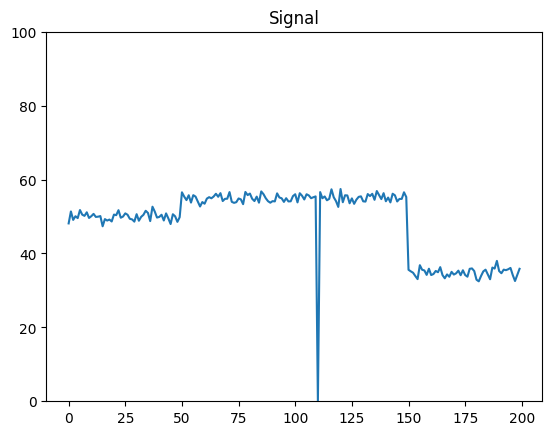

In [4]:
signal = np.random.normal(scale=1, size=200)
signal[:50] += 50; signal[50:] += 55; signal[150:] -= 20
signal[110] = 0

plt.plot(signal)
plt.ylim(0, 100)
plt.title("Signal")
plt.show()

### Сломанный тренд или сезонность

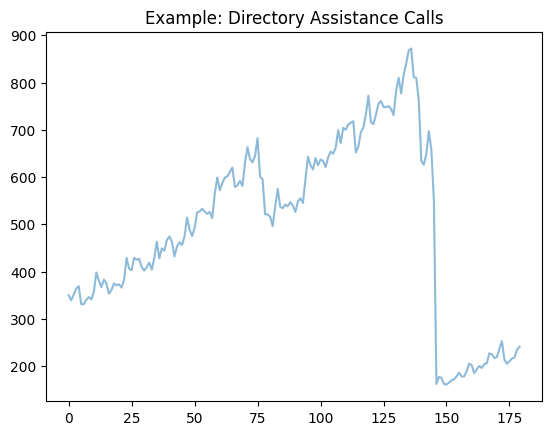

In [5]:
signal = [350,339,351,364,369,331,331,340,346,341,357,398,381,367,383,375,353,361,375,371,373,366,382,429,406,403,429,425,427,409,402,409,419,404,429,463,428,449,444,467,474,463,432,453,462,456,474,514,489,475,492,525,527,533,527,522,526,513,564,599,572,587,599,601,611,620,579,582,592,581,630,663,638,631,645,682,601,595,521,521,516,496,538,575,537,534,542,538,547,540,526,548,555,545,594,643,625,616,640,625,637,634,621,641,654,649,662,699,672,704,700,711,715,718,652,664,695,704,733,772,716,712,732,755,761,748,748,750,744,731,782,810,777,816,840,868,872,811,810,762,634,626,649,697,657,549,162,177,175,162,161,165,170,172,178,186,178,178,189,205,202,185,193,200,196,204,206,227,225,217,219,236,253,213,205,210,216,218,235,241]
plt.plot(signal, alpha = 0.5)
plt.title('Example: Directory Assistance Calls')
plt.show()

### Нарушение периодичности

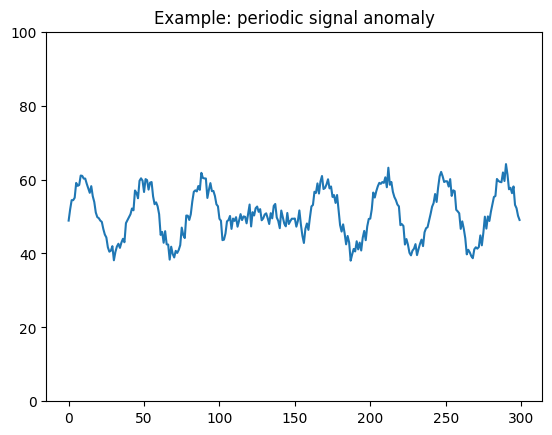

In [6]:
signal = np.sin(np.linspace(0, 15*np.pi, num=300))
signal[105:155] *= 0.1
signal = 10 * signal + 50

noise = np.random.normal(scale = 1.5, size=300)
signal = signal + noise

plt.ylim(0,100)
plt.plot(signal)
plt.title('Example: periodic signal anomaly')
plt.show()

# 1. Простое математическое ожидание 

Рассмотрим ряд

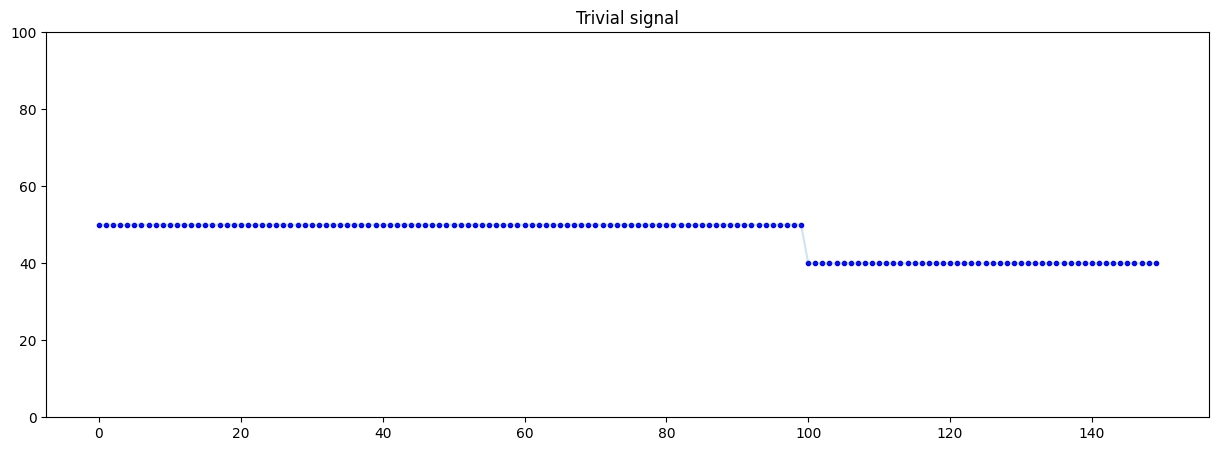

In [17]:
sig1 = np.ones(150)
sig1[:100] *= 50
sig1[100:] *= 40

plt.figure(figsize=(15, 5))
plt.plot(sig1, 'b.')
plt.plot(sig1, '-', alpha=0.2)
plt.ylim(0,100)
plt.title("Trivial signal")
plt.show()

In [18]:
class MeanDetector:
    def __init__(self, threshold=.05):
        self.threshold = threshold
        self.total_val = 0
        self.count = 0
        self.mean = 0
    
    def update(self, new_signal_value):
        self.count += 1
        self.total_val += new_signal_value
        self.mean = self.total_val / self.count
    
    def check(self, new_signal_value):
        threshold_level = self.mean * self.threshold
        
        if np.abs(new_signal_value - self.mean) > threshold_level:
            return True
        return False

In [19]:
def simulate(detector, signal):
    stop_points = []
    for i, value in enumerate(signal):
        detector.update(value)
        if detector.check(value):
            stop_points.append(i)
    plt.figure(figsize=(14, 8))
    plt.plot(signal, 'b.')
    plt.plot(signal, 'b-', alpha=.15)
    plt.title('Signal')
    
    if stop_points:
        plt.vlines(x=stop_points[0], ymin=0, ymax=np.max(signal),
                  colors='r', linestyles='dotted')
    plt.show()

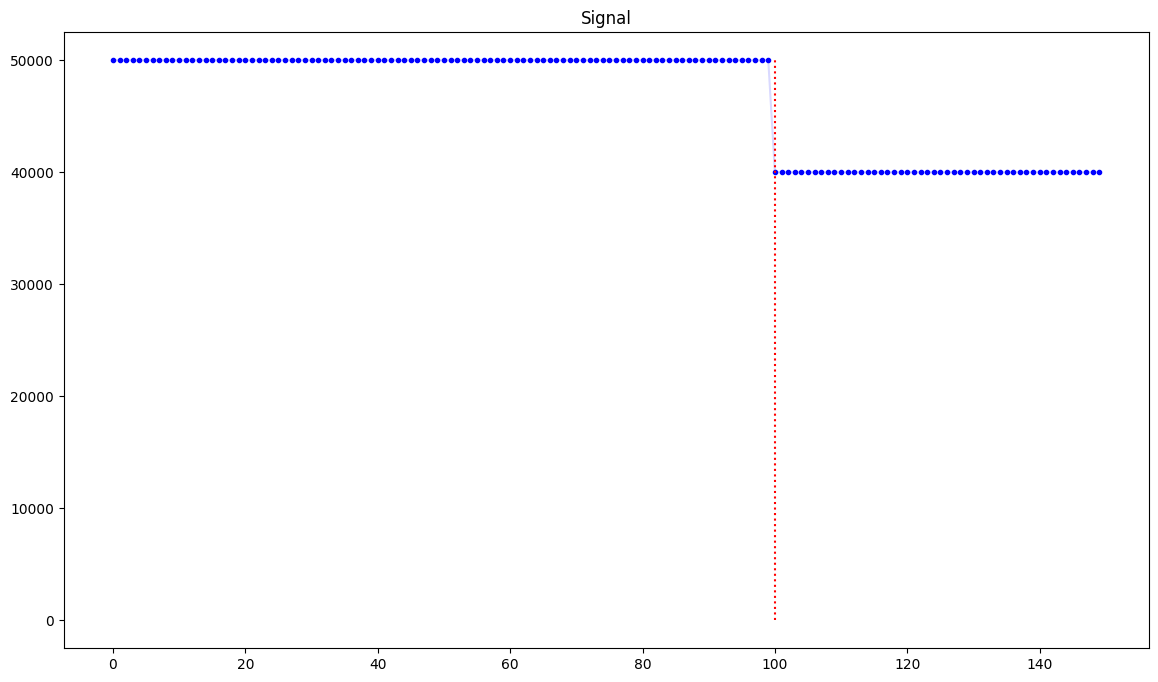

In [21]:
simulate(MeanDetector(), sig1*1000)

# Зашумление

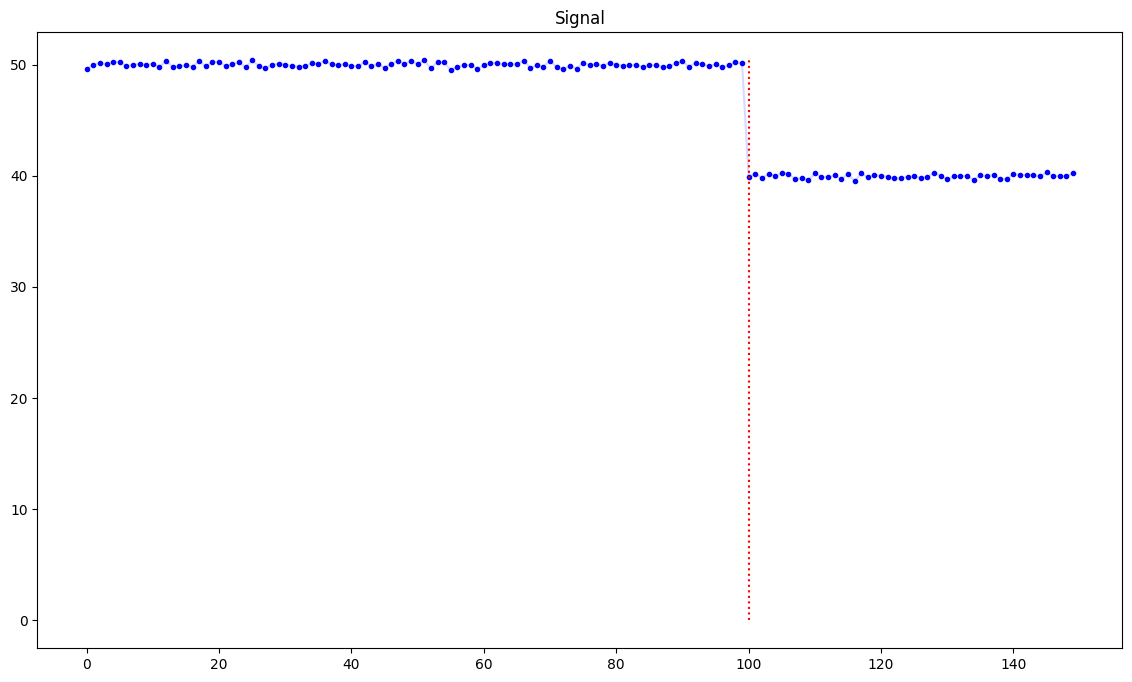

In [22]:
# adding noise 2%
jump_size = sig1[0] - sig1[-1]

noise = np.random.normal(
    size=sig1.shape,
    scale=jump_size * .02)

simulate(MeanDetector(), sig1 + noise)

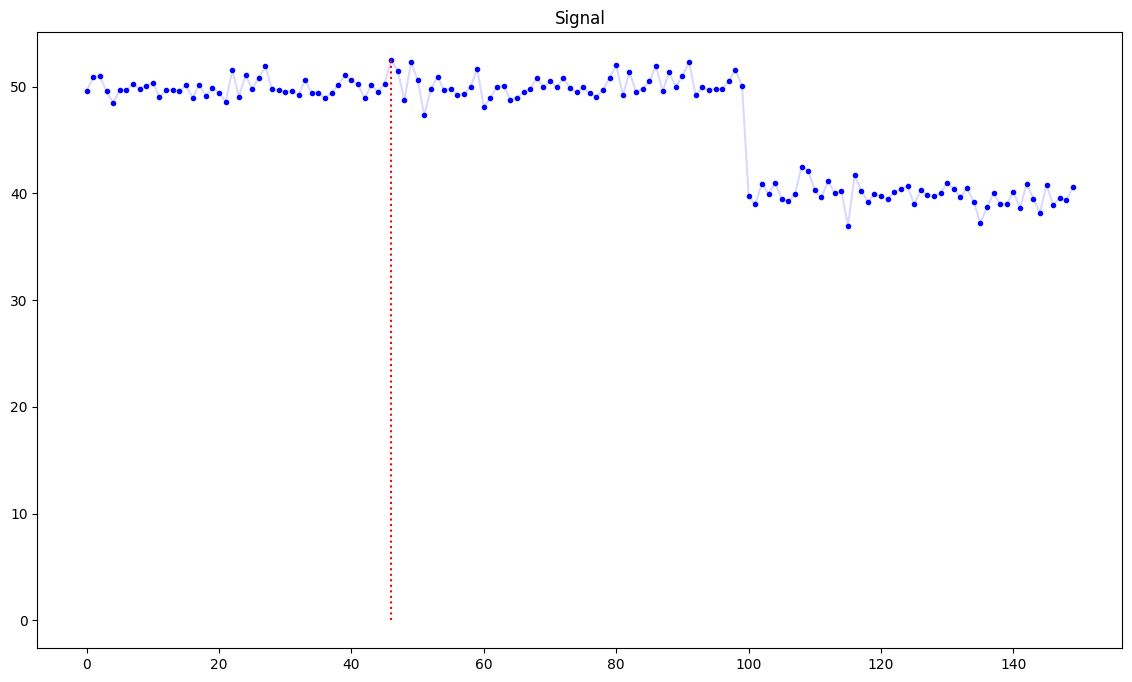

In [24]:
# adding noise 10%
jump_size = sig1[0] - sig1[-1]

noise = np.random.normal(
    size=sig1.shape,
    scale=jump_size * .1)

simulate(MeanDetector(), sig1 + noise)

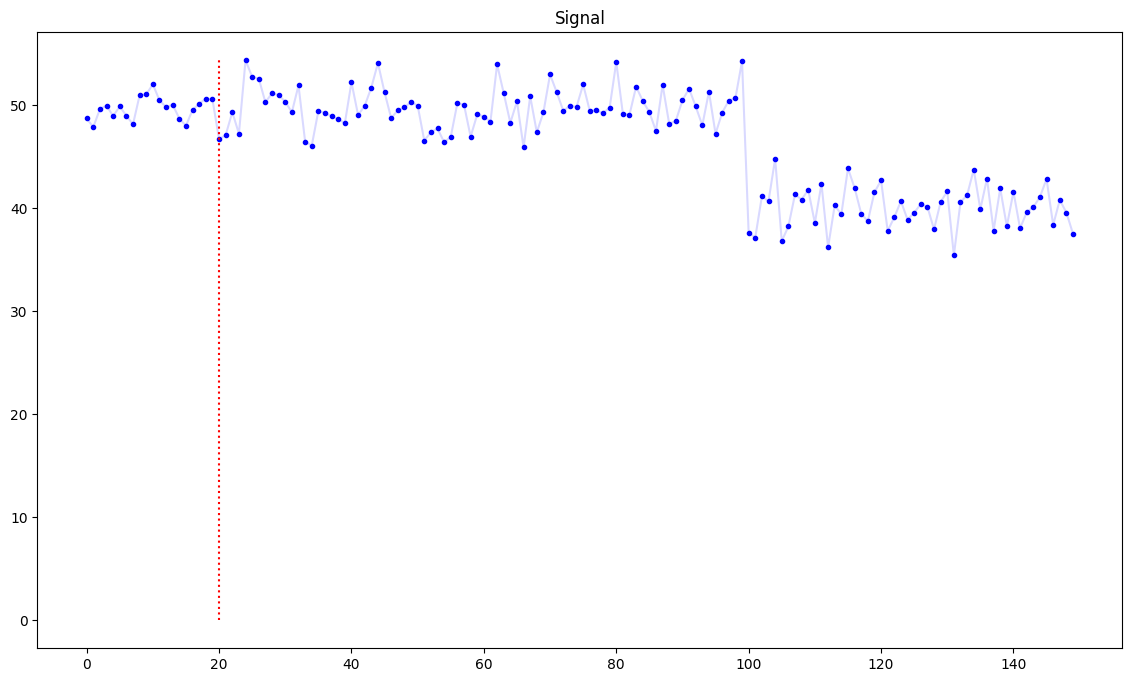

In [25]:
# adding noise 20%
jump_size = sig1[0] - sig1[-1]

noise = np.random.normal(
    size=sig1.shape,
    scale=jump_size * .2)

simulate(MeanDetector(), sig1 + noise)

# Сигнал с сезонностью

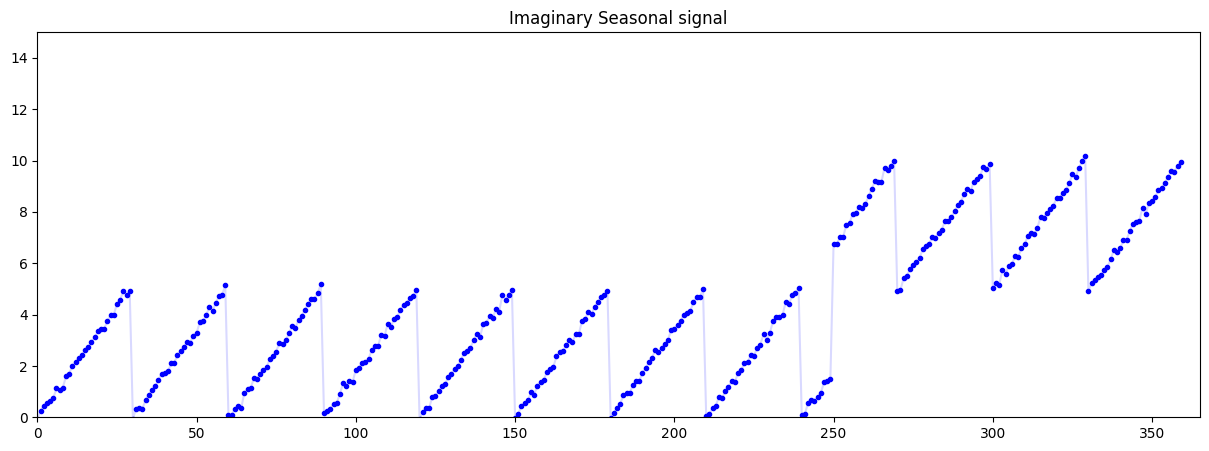

In [27]:
sig2 = np.linspace(0, 5, num=30)
sig2 = np.concatenate([sig2 for x in range(12)])

jump_size = 5
sig2[250:] = sig2[250:] + jump_size

# Noise
noise = np.random.normal(
    size=sig2.shape,
    scale=jump_size * 0.02)

plt.figure(figsize=(15,5))
plt.plot(sig2 + noise, 'b.', linestyle='')
plt.plot(sig2 + noise, 'b-', alpha=0.15)
plt.ylim(0,15)
plt.xlim(0,365)
plt.title("Imaginary Seasonal signal")
plt.show()

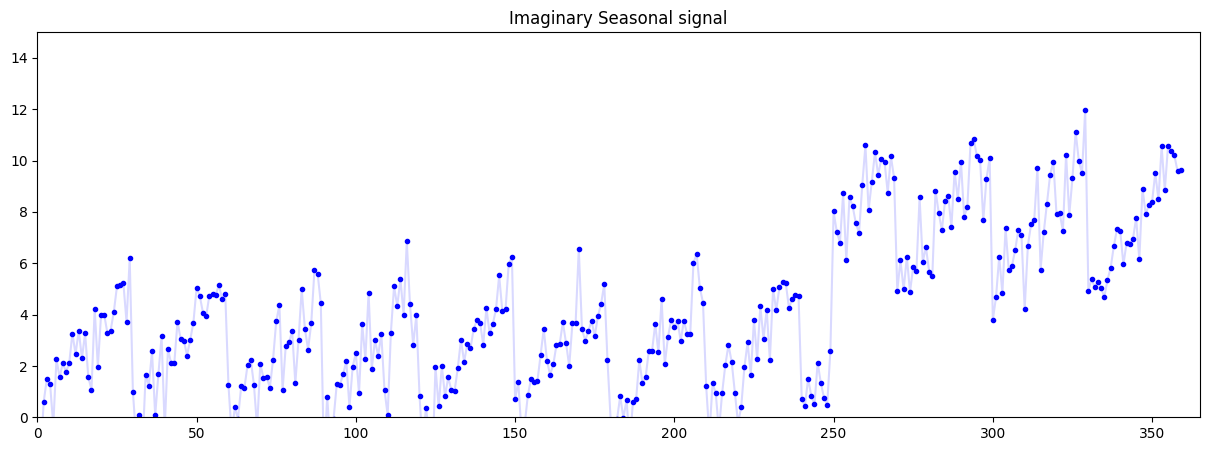

In [26]:
sig2 = np.linspace(0, 5, num=30)
sig2 = np.concatenate([sig2 for x in range(12)])

jump_size = 5
sig2[250:] = sig2[250:] + jump_size

# Noise
noise = np.random.normal(
    size=sig2.shape,
    scale=jump_size * .20)

plt.figure(figsize=(15, 5))
plt.plot(sig2 + noise, 'b.', linestyle='')
plt.plot(sig2 + noise, 'b-', alpha=.15)
plt.ylim(0, 15)
plt.xlim(0, 365)
plt.title('Imaginary Seasonal signal')
plt.show()

In [28]:
def apply_mean_detector(threshold):
    simulate(MeanDetector(threshold=threshold), sig2)

In [36]:
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider

interact(apply_mean_detector, threshold=FloatSlider(min=0, max=10, step=.5));

interactive(children=(FloatSlider(value=0.0, description='threshold', max=10.0, step=0.5), Output()), _dom_cla…

# 2. Потоковые окна

Потоковые окна - это подход к обнаружению изменений, где мы сохраняем статистику (например, среднее значение) на двух отдельных образцах (или окнах) сигнала.

Обычно для одного из окон мы используем только последние $n$ точки данных. Для другого окна мы можем использовать гораздо большее окно или весь сигнал, который мы видели с момента $t = 0$.

Затем мы можем сравнить то, что происходило «недавно» с тем, как сигнал вел себя раньше.

### Остерегайтесь практических ограничений
Зачастую нельзя хранить все данные - нужны "умные" алгоритмы для хранения статистик по точкам.

#### Метод Велфорда
В этом разделе мы будем использовать метод Welford для вычисления среднего значения и дисперсии. 

## zscore

### Zscore (определение)
При сравнении двух гауссовских моделей z-оценка - это расстояние от среднего значения выборки до среднего значения совокупности в единицах стандартной ошибки. Он часто используется для определения того, отличается ли выборка точек данных от исследуемой совокупности.

$$z_{score} = \frac{(M - \sigma)}{SE}$$

 * Совокупность имеет среднее значение $\mu$ и стандартное отклонение $\sigma$.
 * Выборка имеет среднее значение $M$ и размер $n$.
 * SE - это стандартная ошибка:
$$SE = \frac{\sigma}{\sqrt{n}}$$
    

### Использование Zscore

Для нашего следующего детектора точек изменений мы будем поддерживать два набора статистических данных о нашем сигнале и сравнивать их с помощью z-score. Ссылаясь на приведенные выше формулы, нам нужно вычислить среднее и стандартное отклонение для каждого набора.

Мы будем использовать весь сигнал, который мы видели до сих пор, для вычисления статистик совокупности.
Мы будем использовать движущееся окно из последних $n$ точек для вычисления статистик выборки.

In [42]:
class ZScoreDetector:
    def __init__(self, window_size=100, threshold=.05):
        self.threshold = threshold
        self.window_size = window_size
        self.k = 0
        self.g_mean = 0.0 # global mean
        self.s = .0 # for Welford's method. variance = s / (k + 1)
        self.window = deque(maxlen = window_size)
        self.z_score = np.nan
    
    def update(self, new_signal_value):
        x = new_signal_value
        
        #  Добавляем в окно 
        self.window.append(x)
        
        # Считаем статистики
        oldm = self.g_mean
        newm = oldm + (x - oldm) / (self.k + 1)
        s = self.s + (x - newm) * (x - oldm)
        g_mean = newm
        g_std = np.sqrt(s / (self.k + 1))
        
        # Считаем статистики по выборке
        w_mean = np.mean(self.window)
        w_std = np.std(self.window)
        
        # Считаем Z-score 
        std_diff = (g_std - w_std) / g_std
        SE = g_std / np.sqrt(self.window_size)
        mean_diff = (g_mean - w_mean) / g_mean
        self.z_score = (w_mean - g_mean) / SE
        
        # Обновляем атрибуты
        self.g_mean = g_mean
        self.s = s
        
        self.k += 1
    
    def check(self, new_signal_value):
        if np.abs(self.z_score) > self.threshold:
            return True
        return False      

## Проверим на первом ряде

/var/folders/mm/2c6bnjk559g2btv241j7f9lh0000gn/T/ipykernel_1354/3287524339.py:29: RuntimeWarning: invalid value encountered in scalar divide
  std_diff = (g_std - w_std) / g_std
/var/folders/mm/2c6bnjk559g2btv241j7f9lh0000gn/T/ipykernel_1354/3287524339.py:32: RuntimeWarning: invalid value encountered in scalar divide
  self.z_score = (w_mean - g_mean) / SE


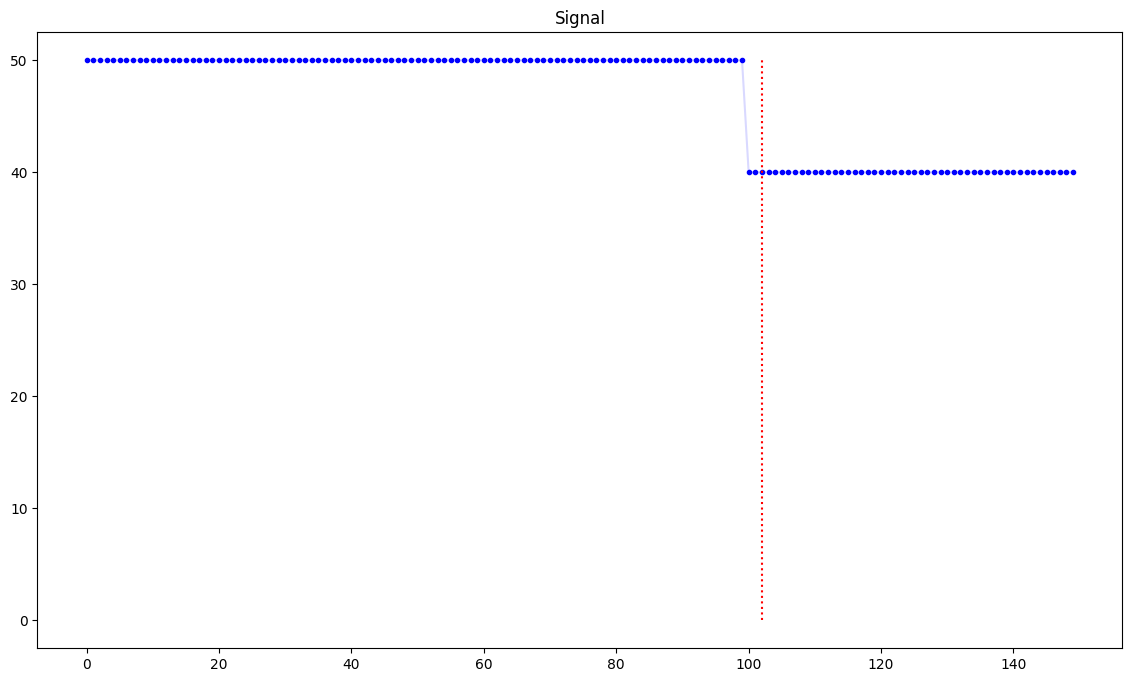

In [43]:
simulate(ZScoreDetector(window_size=10, threshold=5.0), sig1)

/var/folders/mm/2c6bnjk559g2btv241j7f9lh0000gn/T/ipykernel_1354/3287524339.py:29: RuntimeWarning: invalid value encountered in scalar divide
  std_diff = (g_std - w_std) / g_std
/var/folders/mm/2c6bnjk559g2btv241j7f9lh0000gn/T/ipykernel_1354/3287524339.py:31: RuntimeWarning: invalid value encountered in scalar divide
  mean_diff = (g_mean - w_mean) / g_mean
/var/folders/mm/2c6bnjk559g2btv241j7f9lh0000gn/T/ipykernel_1354/3287524339.py:32: RuntimeWarning: invalid value encountered in scalar divide
  self.z_score = (w_mean - g_mean) / SE


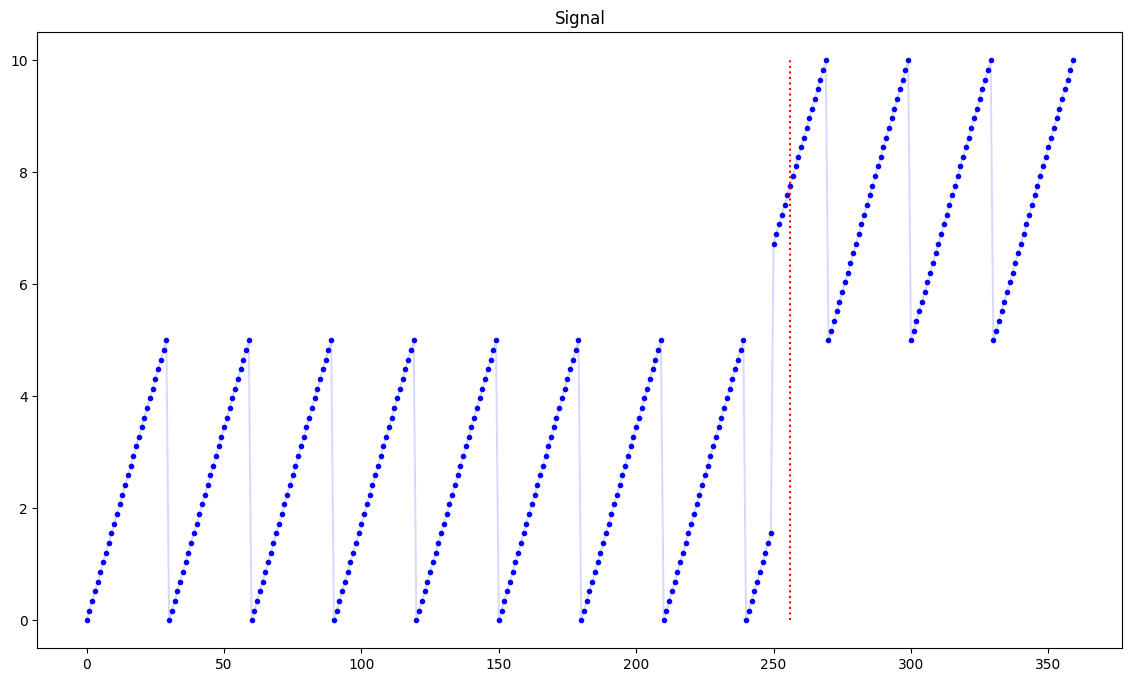

In [45]:
simulate(ZScoreDetector(window_size=10, threshold=5.0), sig2)

# Выбросы

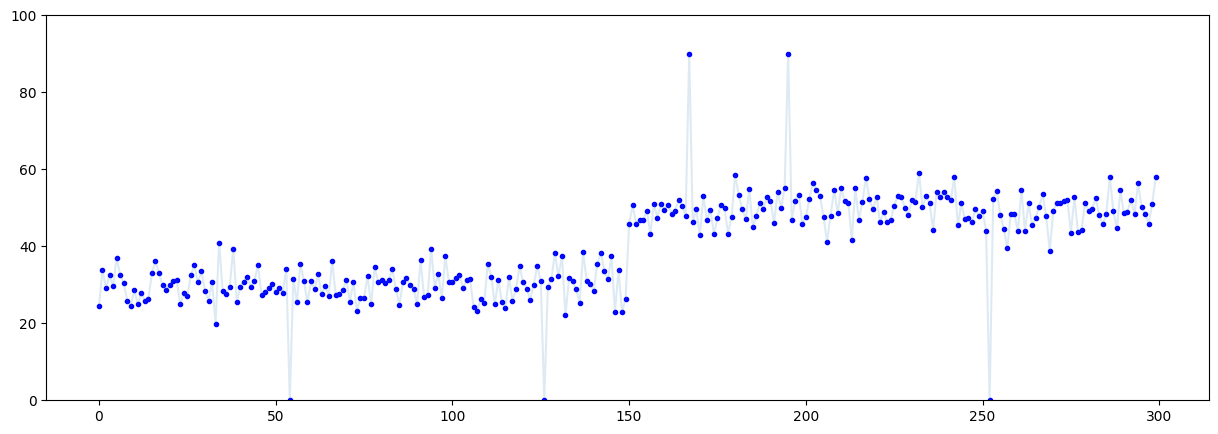

In [55]:
jump_size = 20
signal_size = 300

sig3 = np.ones(signal_size)
sig3[:150] = 30
sig3[150:] = 30 + jump_size

noise = np.random.normal(
    scale = 0.20 * jump_size,
    size=signal_size)

sig3 = sig3 + noise

outlier_idx = np.random.choice(signal_size, size=3)
sig3[outlier_idx] = 0
outlier_idx = np.random.choice(signal_size, size=2)
sig3[outlier_idx] = 90

plt.figure(figsize=(15, 5))
plt.plot(sig3, 'b.')
plt.plot(sig3, '-', alpha=0.15)
plt.ylim(0,100)
plt.show()

/var/folders/mm/2c6bnjk559g2btv241j7f9lh0000gn/T/ipykernel_1354/3287524339.py:29: RuntimeWarning: invalid value encountered in scalar divide
  std_diff = (g_std - w_std) / g_std
/var/folders/mm/2c6bnjk559g2btv241j7f9lh0000gn/T/ipykernel_1354/3287524339.py:32: RuntimeWarning: invalid value encountered in scalar divide
  self.z_score = (w_mean - g_mean) / SE


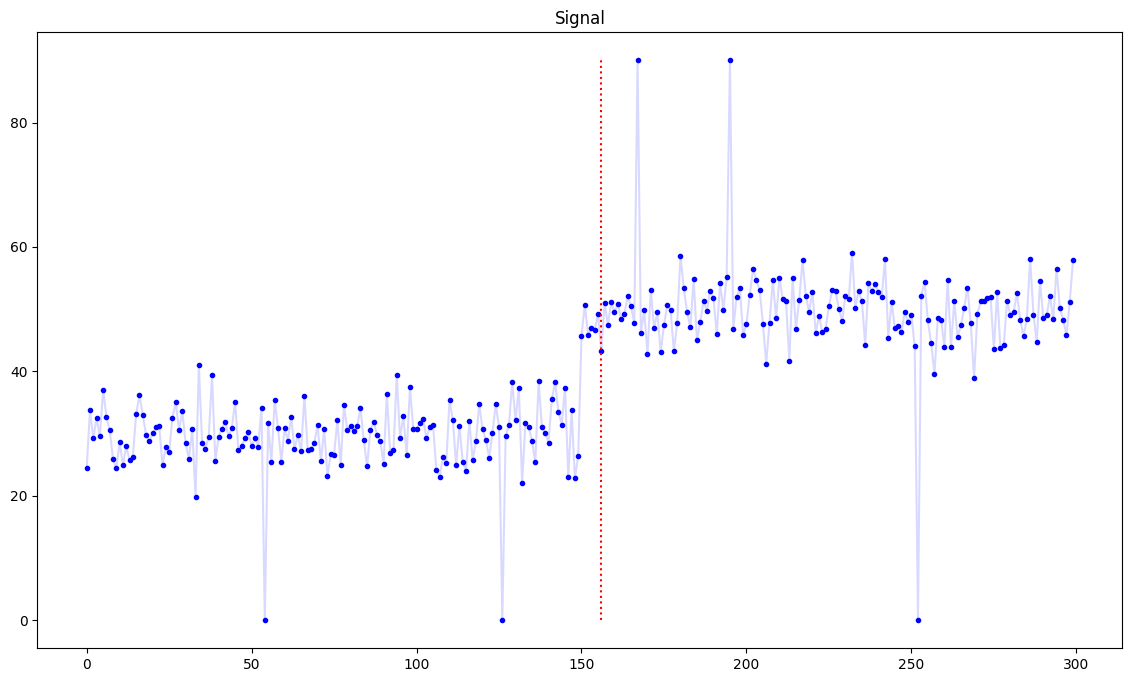

In [56]:
simulate(ZScoreDetector(window_size=10, threshold=5.0), sig3)

In [57]:
def sig1_with_zeros(num_zeros):
    tmp = sig1.copy()
    tmp[50:50 + num_zeros] = 0
    
    simulate(ZScoreDetector(window_size=10, threshold=3.), tmp)

/var/folders/mm/2c6bnjk559g2btv241j7f9lh0000gn/T/ipykernel_1354/3287524339.py:29: RuntimeWarning: invalid value encountered in scalar divide
  std_diff = (g_std - w_std) / g_std
/var/folders/mm/2c6bnjk559g2btv241j7f9lh0000gn/T/ipykernel_1354/3287524339.py:32: RuntimeWarning: invalid value encountered in scalar divide
  self.z_score = (w_mean - g_mean) / SE


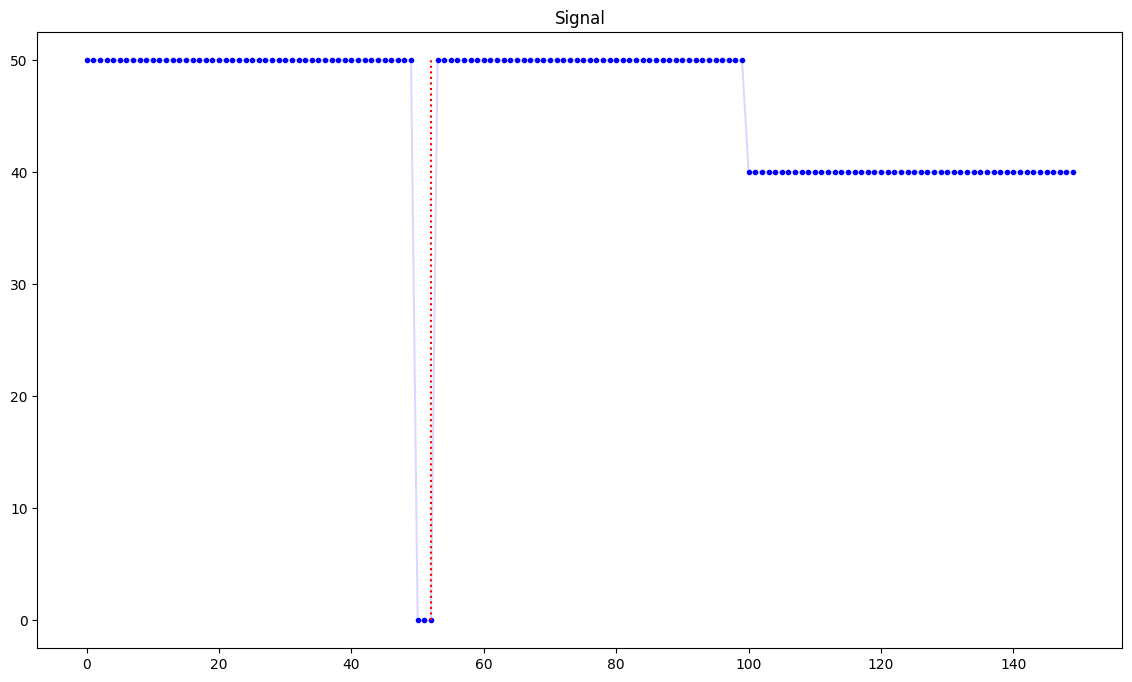

In [58]:
sig1_with_zeros(3)